# Определение возраста покупателей

Проведем исследовательский анализ данных:
* Посмотрим на размер выборки.
* Построим график распределения возраста в выборке.
* Напечатаем на экране 10–15 фотографий и посмотрите, как устроен датасет.
* Сделаем выводы 

Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей
в GPU-тренажёре и сохраним результат вывода модели на экран
* Добеьемся значения MAE на тестовой выборке не больше 8

## Исследовательский анализ данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Просмотрим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


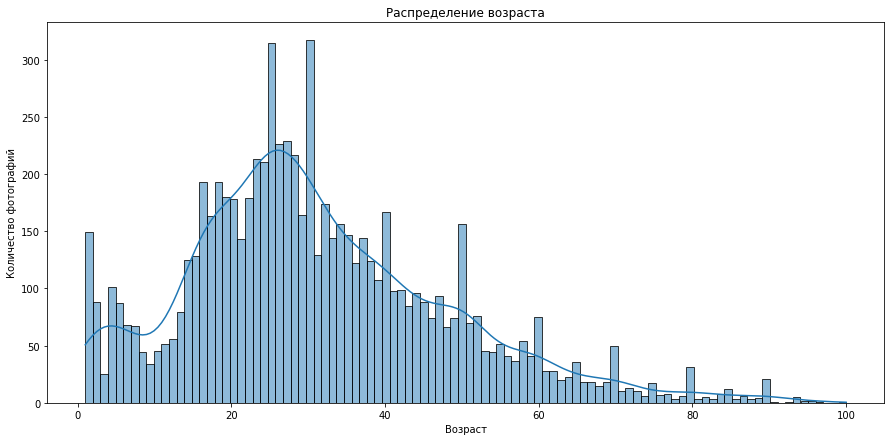

In [6]:
plt.figure(figsize=(15, 7))
sns.histplot(labels['real_age'], kde=True, bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.title('Распределение возраста');

* размер выборки составляет 7591 картинку 
* возраст имеет разброс с 1 года до 100 лет 
* средний возраст составляет 31 год 
* медианный возраст - 29 лет 

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


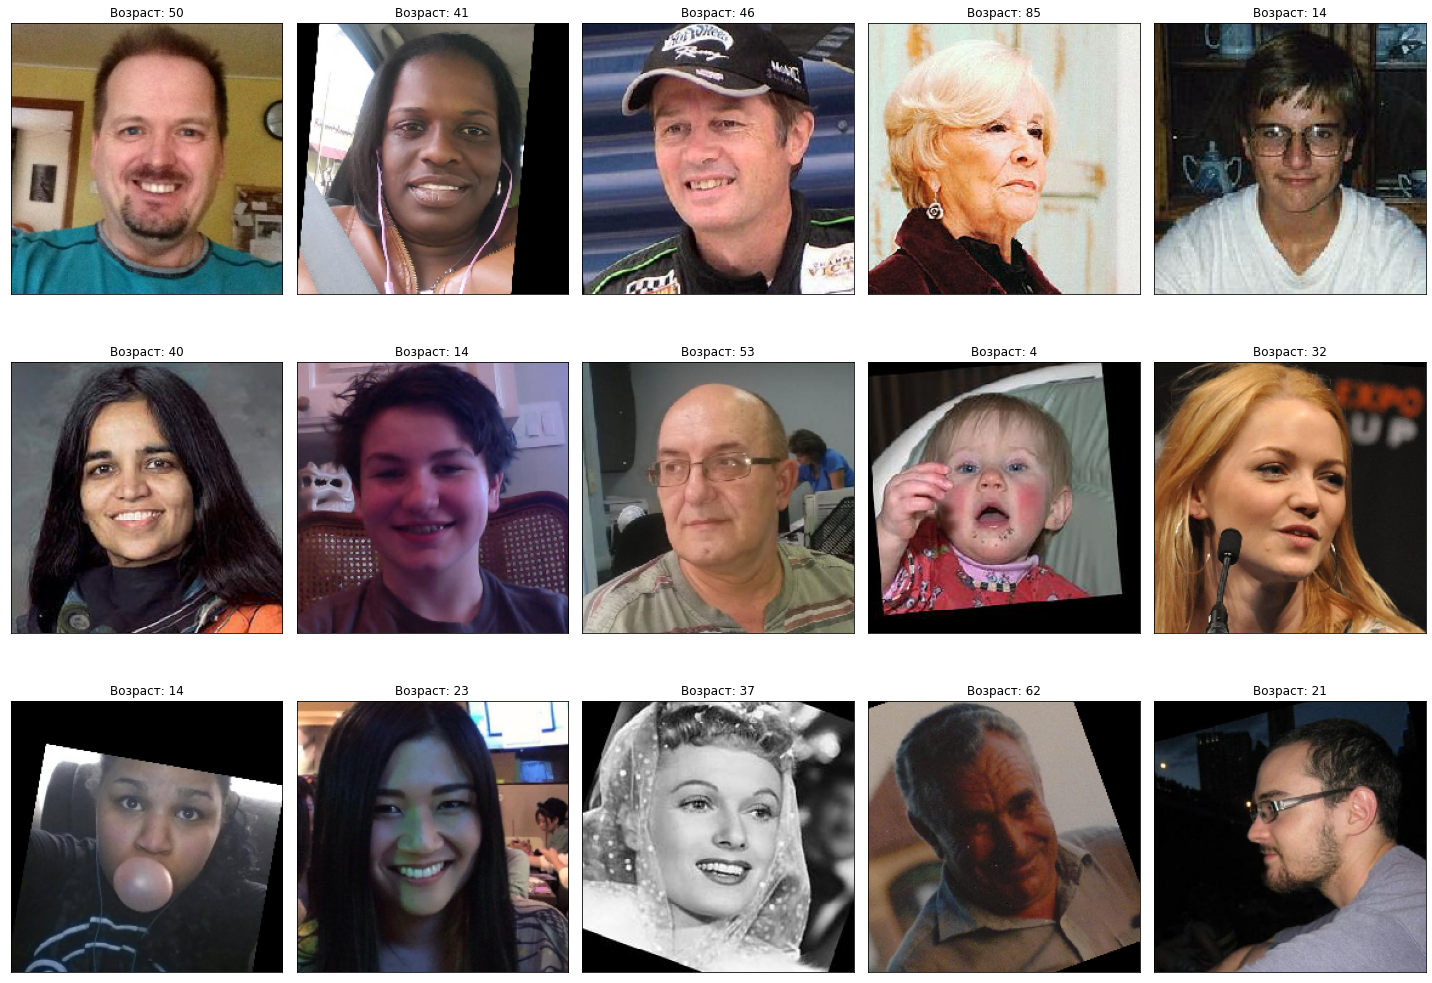

In [8]:
fig = plt.figure(figsize=(20,16))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

* Видим, что к датасету применены аугментации 
* Изображения сдвинуты и повёрнуты случайным образом

In [9]:
features.shape

(32, 224, 224, 3)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=4,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/4
356/356 - 63s - loss: 213.8615 - mae: 10.6038 - val_loss: 516.7137 - val_mae: 17.6483
Epoch 2/4
356/356 - 56s - loss: 70.9782 - mae: 6.3833 - val_loss: 151.4987 - val_mae: 9.6968
Epoch 3/4
356/356 - 41s - loss: 37.9730 - mae: 4.7688 - val_loss: 79.9612 - val_mae: 6.7923
Epoch 4/4
356/356 - 56s - loss: 23.1295 - mae: 3.7120 - val_loss: 71.5669 - val_mae: 6.3706
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 71.5669 - mae: 6.3706
Test MAE: 6.3706


```

## Анализ обученной модели

* Модель ошибается в среднем на 6.3706 лет (MAE = 6.3706)
* Необходимого значения MAE модель смогла достичь за 4 эпохи обучения
* За основу модели была взята сеть ResNet50 
* В параметре weight был использован imagenet
* В качестве функции потерь был задан параметр MSE
* В качестве оптимизатора взят Adam с шагом обучения 0.0001

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы